# Определение возраста покупателей

## Исследовательский анализ данных

**Загрузим библиотеки и данные.**

In [1]:
import numpy as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
faces = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
faces.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выборка содержит 7591 запись. Не слишком много, попробую использовать ResNet.
Пропусков не обнаружено.

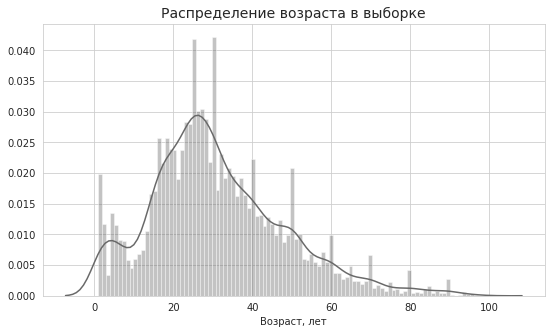

In [5]:
plt.figure(figsize=(9,5))
sns.distplot(faces['real_age'], color='dimgrey', bins=100)
plt.title('Распределение возраста в выборке', size=14)
plt.xlabel('Возраст, лет');

In [6]:
faces['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

Датасет содержит информацию о фотографиях людей от 1 года до 100 лет.  
Основная часть людей на изображениях в возрасте 20-30 лет c пиками 25 и 30 лет.  
Годовалых младенцев больше, чем 10-12 летних детей.  
Встречаются повышенное количество людей в возрасте 40, 50, 60, 70, 80, 90 лет. 

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=faces,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=43)

Found 7591 validated image filenames.


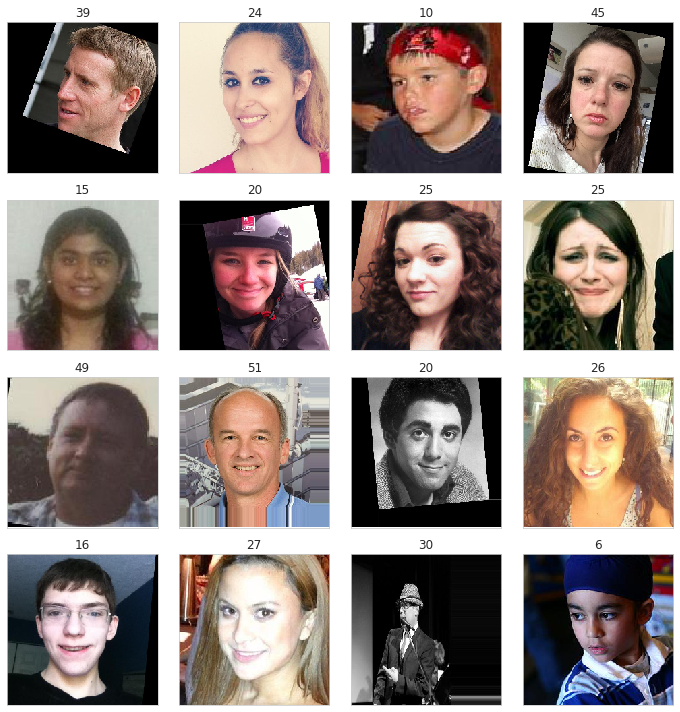

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title(target[i]) #изменено ревьюером
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()    

**Вывод**  
Выборка содердит 7591 запись.  
Целевой признак несбалансирован.  
Больше всего людей в возрасте от 20 до 30 лет, в каждой десятилетней группе выделяются "круглые юбиляры".  
Выдвину предположение о сдвиги предсказаний модели в сторону "молодых людей" 20-30 лет. И тяготении модели к круглым датам.  


1. Если датасет содержит мало данных, его можно увеличить при помощи аугментаций, либо использовать предообученную модель как в ResNet50 weights='imagenet'.  
2. Зависит от того как собирали данные, если пользователь сам вводил данные, по каким-то причинам не хотел ставить возраст. Если делали разметку данных, по анкетным данным и в графе возраст был пропуск, могли по виду фото округлять значения до десятков.  
3. Фотографии разные по качеству, в основном цветные, но бывают и черно-белые, анфас в большей массе, бывают и профили. Углы поворота в 45 градусов, встречаются. Чтобы увеличить выборку горизонтальные повороты и ротация на 45 подошла бы. Но скорость обучения при добавлении аугментаций может увеличиваться.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

###Загрузка лейблов. при выполнении в одном окне - можно было бы взять предыдущий датасет  

labels = pd.read_csv('/datasets/faces/labels.csv')

###Загрузка обучающей подвыборки

def load_train(path):

    train_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255
        #horizontal_flip=True,
        #rotation_range=45
        #width_shift_range=0.2,
        #height_shift_range=0.2
        )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_gen_flow

###Загрузка тестовой подвыборки

def load_test(path):

    test_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255
        )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_gen_flow


### Создание модели     

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    return model

### Обучение модели

def train_model(model, train_data, test_data, batch_size=None, 
                epochs=5, steps_per_epoch=None, validation_steps=None):


    if steps_per_epoch is None:
                 steps_per_epoch = len(train_data)
    if validation_steps is None:
                  validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,        
              verbose=2, 
              shuffle=True)

    return model

```

Было интересно посмотреть, как отработает модель без аугментаций, отработала она на проходной балл. Если качество не устроит заказчика, аугментации всегда можно добавить и улучшить метрику, вместе с увелечением времени обучения.

```

Train for 380 steps, validate for 95 steps
Epoch 1/5
380/380 - 123s - loss: 11.0990 - mae: 11.1059 - val_loss: 19.1961 - val_mae: 19.1923
Epoch 2/5
380/380 - 38s - loss: 7.2504 - mae: 7.2492 - val_loss: 9.5178 - val_mae: 9.5179
Epoch 3/5
380/380 - 37s - loss: 6.0101 - mae: 6.0103 - val_loss: 7.2272 - val_mae: 7.2284
Epoch 4/5
380/380 - 37s - loss: 5.1254 - mae: 5.1258 - val_loss: 7.1137 - val_mae: 7.1163
Epoch 5/5
380/380 - 37s - loss: 4.5291 - mae: 4.5283 - val_loss: 6.7100 - val_mae: 6.7083

95/95 - 8s - loss: 6.7100 - mae: 6.7083
Test MAE: 6.7083

Финальная МАЕ на валидационной выборке = 6.7. Приемленый результат в рамках исследования.
```

## Анализ обученной модели

На валидационной выборке обученная модель ошибается в среднем на 6 лет. Я уверен, что при настройке параметров, можно добиться лучших показателей. 
Обучение 1 эпохи происходит в течение 37-38 секунд. 
  
Цель исследования выполнена: обученная модель демонстрирует показатель MAE = 6.7 без настройки параметров и аугментации данных.
  
- Исходные данные содержали 7.5 тысяч записей, без пропусков и выбросов.   
- Большинство людей на фотографиях запечетлено в возрастном диапазоне 20-30 лет.  
- В каждой 10-летней группе встречается повышенное количество круглых юбиляров (50-60-70 лет).  
- Модель содержит архитектуру ResNet и предобученные на ImageNet сверточные слои.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы